In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand/data

dataset = pd.read_csv(r'C:\Users\selcu\Downloads\\hotel_bookings.csv')
dataset

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


#  Feature Engineering

In [3]:
def feature_engineering(df):
    """
    Adds custom features to the given DataFrame.

    Parameters:
    df (pd.DataFrame): Input dataframe containing hotel booking data.

    Returns:
    pd.DataFrame: Dataframe with new features added.
    """
    
    # Check if the reserved room type matches the assigned room type
    df['is_reserved_room_same_with_assigned_room'] = (df['reserved_room_type'] == df['assigned_room_type']).astype(int)

    # Calculate the ratio of days in the waiting list to the average daily rate (adr)
    # Add a small value (1e-10) to adr to avoid division by zero errors
    df['waiting_list_to_adr_ratio'] = df['days_in_waiting_list'] / (df['adr'] + 1e-10)
    
    # Calculate the lead time to days in waiting list ratio
    # Add a small value (1e-10) to avoid division by zero errors # REMOVED THIS AS IT BECOMES TOO CORRELATED WITH lead_time itself
    #df['lead_time_to_waiting_list_ratio'] = df['lead_time'] / (df['days_in_waiting_list'] + 1e-10)
    
    # Calculate the total_special_requests to adr ratio
    # Add a small value (1e-10) to avoid division by zero errors
    df['total_special_requests_to_adr_ratio'] = df['total_of_special_requests'] / (df['adr'] + 1e-10)
    
    # Calculate lead_time_to_adr_ratio
    # Add a small value (1e-10) to avoid division by zero errors
    df['lead_time_to_adr_ratio'] = df['lead_time'] / (df['adr'] + 1e-10)

    # Calculate weekend to weekday ratio
    # Add a small value (1e-10) to avoid division by zero errors
    df['weekend_weekday_ratio'] = df['stays_in_weekend_nights'] / (df['stays_in_week_nights'] + 1e-10)
    
    # Create is_only_children_booking feature
    df['is_only_children_booking'] = ((df['adults'] == 0) & (df['children'] > 0)).astype(int)
    
    # Create is_only_adult_booking feature
    df['is_only_adult_booking'] = ((df['adults'] > 0) & (df['children'] == 0) & (df['babies'] == 0)).astype(int)

    # Create the arrival_date as a full datetime object from year, month, and day
    df['arrival_date_full'] = pd.to_datetime(
        df['arrival_date_year'].astype(str) + '-' + df['arrival_date_month'] + '-' + df['arrival_date_day_of_month'].astype(str)
    )

    # Get the weekday name for the arrival date (e.g., 'Monday', 'Tuesday', etc.)
    df['arrival_weekday'] = df['arrival_date_full'].dt.day_name()
    
    #A binary feature indicating if a booking includes only adults and is on weekdays—possibly suggesting a business trip, 
    # which may be less prone to cancellation.
    df['is_only_adults_on_weekday'] = (
        (df['adults'] > 0) &
        (df['children'] == 0) &
        (df['babies'] == 0) &
        (df['arrival_weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']))
    ).astype(int)
    
    # Calculate booking date as arrival_date_full minus lead_time days
    df['booking_date_full'] = df['arrival_date_full'] - pd.to_timedelta(df['lead_time'], unit='d')
    
    # Extract year, month, week number, and day of the month from 'booking_date_full'
    df['booking_date_year'] = pd.to_datetime(df['booking_date_full']).dt.year
    df['booking_date_month'] = pd.to_datetime(df['booking_date_full']).dt.month_name()
    df['booking_date_week_number'] = pd.to_datetime(df['booking_date_full']).dt.isocalendar().week.astype('int32')
    df['booking_date_day_of_month'] = pd.to_datetime(df['booking_date_full']).dt.day
    df['booking_weekday'] = df['booking_date_full'].dt.day_name()
    
    # Create season-related features for booking and arrival dates
    season_mapping = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
    }
    df['booking_season'] = df['booking_date_full'].dt.month.map(season_mapping)
    df['arrival_season'] = df['arrival_date_full'].dt.month.map(season_mapping)
    
    # Create integer versions of booking_date_month and arrival_date_month columns
    month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    df['booking_date_month_integer_version'] = df['booking_date_month'].map(month_mapping)
    df['arrival_date_month_integer_version'] = df['arrival_date_month'].map(month_mapping)
    
    # Create special day-related features for booking and arrival dates
    special_days = [
    (1, 1),   # New Year's Day
    (12, 31),  # New Year's Eve
    (12, 25), # Christmas Day
    (12, 24), # Christmas's Eve
    (2, 14),  # Valentine's Day
    (10, 31), # Halloween
    (5, 1)  # Labor Day
    ]
    df['is_booking_on_special_day'] = df.apply(
        lambda x: int((x['booking_date_month_integer_version'], x['booking_date_day_of_month']) in special_days), axis=1)
    df['is_arrival_on_special_day'] = df.apply(
        lambda x: int((x['arrival_date_month_integer_version'], x['arrival_date_day_of_month']) in special_days), axis=1)
    
    # Check if the arrival and booking date is a weekend (Saturday or Sunday)
    df['is_arrival_on_weekend'] = df['arrival_date_full'].dt.weekday.isin([5, 6]).astype(int)
    df['is_booking_on_weekend'] = df['booking_date_full'].dt.weekday.isin([5, 6]).astype(int)
    
    # Calculate number of bookings before a booking 
    df['total_previous_bookings'] = df['previous_cancellations'] + df['previous_bookings_not_canceled']
    
    # Calculate the percentage of cancellations before a booking (if total_previous_bookings is 0, this also becomes 0)
    df['previous_cancellation_percentage'] = df.apply(
    lambda x: (x['previous_cancellations'] / x['total_previous_bookings'] * 100) 
    if x['total_previous_bookings'] > 0 else 0,
    axis=1
    )
    
    # Calculate ratio of the number of changes about a booking and lead time
    # Add a small value (1e-10) to avoid division by zero errors
    df['booking_changes_to_lead_time_ratio'] = df['booking_changes'] / (df['lead_time'] + 1e-10)
    
    # Calculate ratio of the number of changes about a booking and days_in_waiting_list
    # Add a small value (1e-10) to avoid division by zero errors # REMOVED THIS AS IT BECOMES TOO CORRELATED WITH booking_changes itself
    #df['booking_changes_to_days_in_waiting_list_ratio'] = df['booking_changes'] / (df['days_in_waiting_list'] + 1e-10)

    # Calculate ratio of the number of changes about a booking and adr
    # Add a small value (1e-10) to avoid division by zero errors
    df['booking_changes_to_adr_ratio'] = df['booking_changes'] / (df['adr'] + 1e-10)

    # Calculate total_special_requests_to_lead_time_ratio
    # Add a small value (1e-10) to avoid division by zero errors
    df['total_special_requests_to_lead_time_ratio'] = df['total_of_special_requests'] / (df['lead_time'] + 1e-10)

    # Calculate ratio of total_previous_bookings and total_of_special_requests
    # Add a small value (1e-10) to avoid division by zero errors
    df['total_previous_bookings_to_total_special_requests_ratio'] = df['total_previous_bookings'] / (df['total_of_special_requests'] + 1e-10)

    # Calculate ratio of days_in_waiting_list and total_of_special_requests
    # Add a small value (1e-10) to avoid division by zero errors # REMOVED THIS AS IT BECOMES TOO CORRELATED WITH days_in_waiting_list itself
    #df['days_in_waiting_list_to_total_special_requests_ratio'] = df['days_in_waiting_list'] / (df['total_of_special_requests'] + 1e-10)

    # Create a binary feature indicating if a guest's reserved premium room was downgraded to a non-premium room
    # Room types H, G, F, and C are identified as premium due to their higher average ADR (Average Daily Rate)
    # compared to other room types in the dataset
    premium_rooms = ['H', 'G', 'F', 'C']

    df['is_premium_room_downgraded'] = (
        df['reserved_room_type'].isin(premium_rooms) &
        ~df['assigned_room_type'].isin(premium_rooms)
    ).astype(int)

    # Create a new binary feature indicating whether the room was upgraded to a premium room
    df['is_room_upgraded_to_premium'] = (
    ~df['reserved_room_type'].isin(premium_rooms) &  # Reserved room is not premium
     df['assigned_room_type'].isin(premium_rooms)   # But assigned room is premium
    ).astype(int)
    
    # Early booking with refundable deposit — could be cancellation prone
    df['is_early_refundable_booking'] = ((df['lead_time'] > 90) & (df['deposit_type'] == 'Refundable')).astype(int)

    # Late booking with non-refundable deposit — likely to show up
    df['is_late_non_refundable_booking'] = ((df['lead_time'] < 30) & (df['deposit_type'] == 'Non Refund')).astype(int)
    
    # Ratio of lead_time to total stay length — shows how early the booking was made relative to stay duration
    # Add a small value to avoid division by zero
    df['lead_time_to_total_stay_ratio'] = df['lead_time'] / (df['stays_in_weekend_nights'] + df['stays_in_week_nights'] + 1e-10)

    # Create binary feature for reservations with meal type 'Undefined' or 'SC', and total stay duration (weekend + weekday nights) > 3
    df['is_long_stay_no_meal'] = df.apply(
        lambda x: (x['meal'] in ['Undefined', 'SC']) and ((x['stays_in_weekend_nights'] + x['stays_in_week_nights']) > 3),
        axis=1
    ).astype(int)

    # Create binary feature for bookings with children or babies but meal type is 'Undefined' or 'SC'
    # This may indicate families who might be more likely to cancel due to lack of included meals
    df['has_kids_but_no_meal'] = df.apply(
        lambda x: ((x['children'] + x['babies']) > 0) and (x['meal'] in ['Undefined', 'SC']),
        axis=1
    ).astype(int)
    
    #fillna for country
    df['country'] = df['country'].fillna('unknown')
    
    # create new column "is_low_activity_agent"
    df['agent'] = df['agent'].fillna('unknown')
    df['agent'] = df['agent'].astype(str) #agent column is logically categorical
    # Count agent IDs
    agent_counts = df['agent'].value_counts()
    # Identify agents with fewer than 1000 bookings — considered low-activity agents
    rare_agents = agent_counts[agent_counts < 1000].index
    # create the column
    df['is_low_activity_agent'] = df['agent'].isin(rare_agents).astype(int)
    
    # Calculate group size
    df["children"] = df["children"].astype("Int64") #first fix dtype of children column
    df["total_people"] = df["adults"] + df["children"] + df["babies"]
    
    # Hotel is probably in Portugal bcs most of the bookings are made from Portugal, so let's check if booking was made by a foreigner
    #df["is_booking_foreign"] = (df["country"] != "PRT").astype(int) # REMOVED AS THIS BECOMES 0.98 CORRELATED WITH country_frequency_encoded COLUMN

    # Check if they changed the room of a loyal customer
    df["is_repeated_guest_but_changed_room"] = ((df["is_repeated_guest"] == 1) & (df["reserved_room_type"] != df["assigned_room_type"])).astype(int)

    # Check if the booking was made late
    df["is_late_booking"] = (df["lead_time"] < 7).astype(int)

    # Check if it is a solo traveler
    df["is_solo_traveler"] = ((df["adults"] + df["children"] + df["babies"]) == 1).astype("Int64")

    return df

In [4]:
#generate all new features
feature_engineering(dataset)

#drop unnecessary or unusable columns for modeling
dataset = dataset.drop(columns=['arrival_date_year', "arrival_date_day_of_month", "company","reservation_status","reservation_status_date","arrival_date_full","booking_date_full","booking_date_year","booking_date_day_of_month","booking_date_month_integer_version","arrival_date_month_integer_version"])

dataset

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,is_early_refundable_booking,is_late_non_refundable_booking,lead_time_to_total_stay_ratio,is_long_stay_no_meal,has_kids_but_no_meal,is_low_activity_agent,total_people,is_repeated_guest_but_changed_room,is_late_booking,is_solo_traveler
0,Resort Hotel,0,342,July,27,0,0,2,0,0,...,0,0,3.420000e+12,0,0,0,2,0,0,0
1,Resort Hotel,0,737,July,27,0,0,2,0,0,...,0,0,7.370000e+12,0,0,0,2,0,0,0
2,Resort Hotel,0,7,July,27,0,1,1,0,0,...,0,0,7.000000e+00,0,0,0,1,0,0,1
3,Resort Hotel,0,13,July,27,0,1,1,0,0,...,0,0,1.300000e+01,0,0,1,1,0,0,1
4,Resort Hotel,0,14,July,27,0,2,2,0,0,...,0,0,7.000000e+00,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,August,35,2,5,2,0,0,...,0,0,3.285714e+00,0,0,1,2,0,0,0
119386,City Hotel,0,102,August,35,2,5,3,0,0,...,0,0,1.457143e+01,0,0,0,3,0,0,0
119387,City Hotel,0,34,August,35,2,5,2,0,0,...,0,0,4.857143e+00,0,0,0,2,0,0,0
119388,City Hotel,0,109,August,35,2,5,2,0,0,...,0,0,1.557143e+01,0,0,1,2,0,0,0


In [5]:
#see the remaining column list to check if the remanining are really the usable columns and in correct dtype

for col in dataset.columns:
    print(f"{col}: {dataset[col].dtype}")
    print(dataset[col].unique())
    print("-" * 40)

hotel: object
['Resort Hotel' 'City Hotel']
----------------------------------------
is_canceled: int64
[0 1]
----------------------------------------
lead_time: int64
[342 737   7  13  14   0   9  85  75  23  35  68  18  37  12  72 127  78
  48  60  77  99 118  95  96  69  45  40  15  36  43  70  16 107  47 113
  90  50  93  76   3   1  10   5  17  51  71  63  62 101   2  81 368 364
 324  79  21 109 102   4  98  92  26  73 115  86  52  29  30  33  32   8
 100  44  80  97  64  39  34  27  82  94 110 111  84  66 104  28 258 112
  65  67  55  88  54 292  83 105 280 394  24 103 366 249  22  91  11 108
 106  31  87  41 304 117  59  53  58 116  42 321  38  56  49 317   6  57
  19  25 315 123  46  89  61 312 299 130  74 298 119  20 286 136 129 124
 327 131 460 140 114 139 122 137 126 120 128 135 150 143 151 132 125 157
 147 138 156 164 346 159 160 161 333 381 149 154 297 163 314 155 323 340
 356 142 328 144 336 248 302 175 344 382 146 170 166 338 167 310 148 165
 172 171 145 121 178 305 173 

<IntegerArray>
[2, 1, 3, 4, 5, 12, 40, 26, 50, 27, 55, 0, 20, 6, 10, <NA>]
Length: 16, dtype: Int64
----------------------------------------
is_repeated_guest_but_changed_room: int32
[0 1]
----------------------------------------
is_late_booking: int32
[0 1]
----------------------------------------
is_solo_traveler: Int64
<IntegerArray>
[0, 1, <NA>]
Length: 3, dtype: Int64
----------------------------------------


## Feature Selection

Using the code below, I removed some created features because they had correlations with some other columns bigger than 0.9. Removed features are turned into comments in feature engineering function above, and I also noted down removal reason as well.

In [6]:
#Sort numerical value columns' correlations (absolute values) to check if there is any pair more correlated than 0.9 

# Select only numeric columns (integer and float)
numeric_columns = dataset.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric columns
corr_matrix = numeric_columns.corr()

# Get the absolute values of the correlation matrix
abs_corr_matrix = corr_matrix.abs()

# Create an empty list to store the correlation pairs
corr_pairs = []

# Iterate over the upper triangle of the matrix (excluding the diagonal)
for i in range(len(abs_corr_matrix.columns)):
    for j in range(i):
        corr_pairs.append((abs_corr_matrix.columns[i], abs_corr_matrix.columns[j], abs_corr_matrix.iloc[i, j]))

# Sort the pairs by correlation value in descending order
sorted_corr_pairs = sorted(corr_pairs, key=lambda x: x[2], reverse=True)

# Display the sorted pairs
for pair in sorted_corr_pairs:
    print(f"({pair[0]}, {pair[1]}) : {pair[2]}")

(total_previous_bookings, previous_bookings_not_canceled) : 0.8897320845445883
(is_only_adult_booking, children) : 0.8859137116045914
(is_arrival_on_weekend, is_only_adults_on_weekday) : 0.8784364847659373
(total_people, adults) : 0.821101737906848
(is_solo_traveler, adults) : 0.7141868993124597
(total_previous_bookings_to_total_special_requests_ratio, previous_cancellations) : 0.7034924703721543
(total_previous_bookings_to_total_special_requests_ratio, total_previous_bookings) : 0.6827210122044832
(is_solo_traveler, total_people) : 0.6473286258984218
(total_previous_bookings, previous_cancellations) : 0.5870148527563465
(total_people, children) : 0.5793734881598679
(total_people, is_only_adult_booking) : 0.5540918314770017
(is_repeated_guest_but_changed_room, is_repeated_guest) : 0.5212959580886619
(stays_in_week_nights, stays_in_weekend_nights) : 0.4989688184955315
(lead_time_to_total_stay_ratio, lead_time_to_adr_ratio) : 0.4690292841272949
(is_arrival_on_weekend, stays_in_weekend_ni

# Dealing with categorical features

one hot encoding list: hotel, arrival_date_month, meal, market_segment, distribution_channel, reserved_room_type, assigned_room_type, deposit_type, customer_type, arrival_weekday, booking_date_month, booking_weekday, booking_season, arrival_season, 

frequency encoding list: country, agent

circular encoding list: arrival_date_week_number, booking_date_week_number

In [7]:
#Apply one hot encoding first
columns_to_encode = [
    'hotel', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel', 
    'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 
    'arrival_weekday', 'booking_date_month', 'booking_weekday', 'booking_season', 'arrival_season'
]

# Apply One-Hot Encoding to the specified columns
dataset_encoded = pd.get_dummies(dataset, columns=columns_to_encode, drop_first=True, dtype=int)

# If you want to modify the original dataset in place, you can assign it back to the original dataset variable
dataset = dataset_encoded

# Print the first few rows to check the encoding
dataset.head()

,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,country,is_repeated_guest,...,booking_weekday_Sunday,booking_weekday_Thursday,booking_weekday_Tuesday,booking_weekday_Wednesday,booking_season_Spring,booking_season_Summer,booking_season_Winter,arrival_season_Spring,arrival_season_Summer,arrival_season_Winter
0,0,342,27,0,0,2,0,0,PRT,0,...,0,1,0,0,0,1,0,0,1,0
1,0,737,27,0,0,2,0,0,PRT,0,...,0,0,0,0,0,1,0,0,1,0
2,0,7,27,0,1,1,0,0,GBR,0,...,0,0,0,1,0,1,0,0,1,0
3,0,13,27,0,1,1,0,0,GBR,0,...,0,1,0,0,0,1,0,0,1,0
4,0,14,27,0,2,2,0,0,GBR,0,...,0,0,0,1,0,1,0,0,1,0


In [8]:
# Apply frequency encoding
columns_to_encode_freq = ['country', 'agent']

# Frequency encoding function
def frequency_encode(df, column):
    freq_map = df[column].value_counts().to_dict()  # Get the frequency of each category
    df[column + '_frequency_encoded'] = df[column].map(freq_map)  # Map frequencies to the new column
    return df

# Apply frequency encoding to the specified columns
for col in columns_to_encode_freq:
    dataset = frequency_encode(dataset, col)
    
# Print the first few rows to check the encoding
dataset[['country', 'country_frequency_encoded', 'agent', 'agent_frequency_encoded']].head()

#drop the columns that is encoded
dataset = dataset.drop(columns=columns_to_encode_freq)

In [9]:
# Apply circular encoding
def circular_encode(df, column):
    # Normalize the values (0 to 1 range) based on the maximum value of the week numbers
    max_val = df[column].max()
    df[column + '_sin'] = np.sin(2 * np.pi * df[column] / max_val)
    df[column + '_cos'] = np.cos(2 * np.pi * df[column] / max_val)

# Apply circular encoding to 'arrival_date_week_number' and 'booking_date_week_number'
circular_encode(dataset, 'arrival_date_week_number')
circular_encode(dataset, 'booking_date_week_number')

#drop the columns that is encoded
dataset = dataset.drop(columns=["arrival_date_week_number", "booking_date_week_number"])

dataset.head()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,booking_season_Winter,arrival_season_Spring,arrival_season_Summer,arrival_season_Winter,country_frequency_encoded,agent_frequency_encoded,arrival_date_week_number_sin,arrival_date_week_number_cos,booking_date_week_number_sin,booking_date_week_number_cos
0,0,342,0,0,2,0,0,0,0,0,...,0,0,1,0,48590,16340,-0.059241,-0.998244,-0.403123,-0.915146
1,0,737,0,0,2,0,0,0,0,0,...,0,0,1,0,48590,16340,-0.059241,-0.998244,0.059241,-0.998244
2,0,7,0,1,1,0,0,0,0,0,...,0,0,1,0,12129,16340,-0.059241,-0.998244,0.059241,-0.998244
3,0,13,0,1,1,0,0,0,0,0,...,0,0,1,0,12129,1,-0.059241,-0.998244,0.176890,-0.984231
4,0,14,0,2,2,0,0,0,0,0,...,0,0,1,0,12129,13922,-0.059241,-0.998244,0.176890,-0.984231


#THIS IS A CODE I WROTE TO UNDERSTAND AND BE SURE CIRCULAR ENCODING IS CORRECT

import numpy as np
import matplotlib.pyplot as plt

#Initialize lists to store x and y coordinates
x_coords = []
y_coords = []

#Loop over var values from 1 to 53
for var in range(1, 54):
    x = np.sin(2 * np.pi * var / 53)
    y = np.cos(2 * np.pi * var / 53)
    x_coords.append(x)
    y_coords.append(y)

    #Plot the points
    plt.figure(figsize=(6,6))
    plt.scatter(x_coords, y_coords)
    plt.title('Points Generated by Circular Encoding')
    plt.xlabel('sin(2πvar/53)')
    plt.ylabel('cos(2πvar/53)')
    plt.gca().set_aspect('equal')  # Make it a circle
    plt.grid(True)
    plt.show()

# Splitting

In [10]:
from sklearn.model_selection import train_test_split

# First, split the data into 70% training and 30% test sets
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42, shuffle=False)

# Then, split the 30% test set into 50% validation and 50% holdout test sets
val_data, holdout_test_data = train_test_split(test_data, test_size=0.5, random_state=42, shuffle=False)

# Let's check the shape of each dataset
print(f"Training Set: {train_data.shape}")
print(f"Validation Set: {val_data.shape}")
print(f"Holdout Test Set: {holdout_test_data.shape}")

Training Set: (83573, 132)
Validation Set: (17908, 132)
Holdout Test Set: (17909, 132)


# Data Cleaning

## Handling missing values

In [11]:
# Check missing values in each column for each dataframe
# train_data, validation_data, test_data are the dataframes you're working with

for df_name, df in [('Train Data', train_data), ('Validation Data', val_data), ('Hold-Out Test Data', holdout_test_data)]:
    print(f"\n{df_name}:")
    missing_values = df.isnull().sum()  # Count the missing values in each column
    missing_columns = missing_values[missing_values > 0]  # Filter columns with missing values
    print(missing_columns)


Train Data:
children            4
total_people        4
is_solo_traveler    4
dtype: int64

Validation Data:
Series([], dtype: int64)

Hold-Out Test Data:
Series([], dtype: int64)


In [12]:
# We have to use train set's parameters to fill missing values to prevent data leakage
# So, let's calculate train set's parameters for necessary columns
children_column_fill_value = train_data['children'].mode()[0]
total_people_column_fill_value = train_data['total_people'].mode()[0]
is_solo_traveler_column_fill_value = train_data['is_solo_traveler'].mode()[0]

In [13]:
#Fill train data:
# Fill missing values in 'children' column with the mode of the column
train_data['children'].fillna(children_column_fill_value, inplace=True)
# Fill missing values in 'total_people' column with the mode of the column
train_data['total_people'].fillna(total_people_column_fill_value, inplace=True)
# Fill missing values in 'is_solo_traveler' column with the mode of the column
train_data['is_solo_traveler'].fillna(is_solo_traveler_column_fill_value, inplace=True)

In [14]:
# Check missing values in each column for each dataframe AGAIN
# train_data, validation_data, test_data are the dataframes you're working with

for df_name, df in [('Train Data', train_data), ('Validation Data', val_data), ('Hold-Out Test Data', holdout_test_data)]:
    print(f"\n{df_name}:")
    missing_values = df.isnull().sum()  # Count the missing values in each column
    missing_columns = missing_values[missing_values > 0]  # Filter columns with missing values
    print(missing_columns)


Train Data:
Series([], dtype: int64)

Validation Data:
Series([], dtype: int64)

Hold-Out Test Data:
Series([], dtype: int64)


## Dropping illogical rows

1. Define a function to count illogical rows where 'adults' is 0, but 'babies' is greater than 0, which is illogical as babies should be accompanied by at least one adult.

In [15]:
def count_illogical_rows(df):
    return df[(df['adults'] == 0) & (df['babies'] > 0)].shape[0]

# Apply the function to the three dataframes and print the result
print(f"Illogical rows in train_data: {count_illogical_rows(train_data)}")
print(f"Illogical rows in val_data: {count_illogical_rows(val_data)}")
print(f"Illogical rows in holdout_test_data: {count_illogical_rows(holdout_test_data)}")

Illogical rows in train_data: 2
Illogical rows in val_data: 1
Illogical rows in holdout_test_data: 0


In [16]:
# Drop these rows directly for each dataframe
train_data = train_data[(train_data['adults'] != 0) | (train_data['babies'] == 0)]
val_data = val_data[(val_data['adults'] != 0) | (val_data['babies'] == 0)]
holdout_test_data = holdout_test_data[(holdout_test_data['adults'] != 0) | (holdout_test_data['babies'] == 0)]

# Print the shape of cleaned dataframes to check how many rows were dropped
print(f"Train data shape after dropping illogical rows: {train_data.shape}")
print(f"Validation data shape after dropping illogical rows: {val_data.shape}")
print(f"Holdout test data shape after dropping illogical rows: {holdout_test_data.shape}")

Train data shape after dropping illogical rows: (83571, 132)
Validation data shape after dropping illogical rows: (17907, 132)
Holdout test data shape after dropping illogical rows: (17909, 132)


2. Check if any column has negative values.

In [17]:
# Train data: Columns with negative values
negative_columns_train = (train_data.select_dtypes(include=['number']) < 0).any()
negative_columns_train = negative_columns_train[negative_columns_train].index.tolist()
print(f"Train Data - Columns with negative values: {negative_columns_train}")

# Validation data: Columns with negative values
negative_columns_val = (val_data.select_dtypes(include=['number']) < 0).any()
negative_columns_val = negative_columns_val[negative_columns_val].index.tolist()
print(f"Validation Data - Columns with negative values: {negative_columns_val}")

# Holdout test data: Columns with negative values
negative_columns_holdout = (holdout_test_data.select_dtypes(include=['number']) < 0).any()
negative_columns_holdout = negative_columns_holdout[negative_columns_holdout].index.tolist()
print(f"Holdout Test Data - Columns with negative values: {negative_columns_holdout}")

Train Data - Columns with negative values: ['adr', 'lead_time_to_adr_ratio', 'booking_changes_to_adr_ratio', 'arrival_date_week_number_sin', 'arrival_date_week_number_cos', 'booking_date_week_number_sin', 'booking_date_week_number_cos']
Validation Data - Columns with negative values: ['arrival_date_week_number_sin', 'arrival_date_week_number_cos', 'booking_date_week_number_sin', 'booking_date_week_number_cos']
Holdout Test Data - Columns with negative values: ['arrival_date_week_number_sin', 'arrival_date_week_number_cos', 'booking_date_week_number_sin', 'booking_date_week_number_cos']


In [18]:
# It is normal to have negative values in sin-cos related columns. All other negatives which are in train set are caused 
# by only one negative value in adr column, which you can see below.
train_data["adr"].sort_values(ascending=True).head(5)

14969   -6.38
0        0.00
30972    0.00
30947    0.00
30941    0.00
Name: adr, dtype: float64

In [19]:
before_count = len(train_data)

#This line will be enough to get rid of all illogical negative values, (we are dropping only 1 row actually)
train_data = train_data[train_data['adr'] >= 0]

after_count = len(train_data)

# Sonuçları yazdır
print(f"Before: {before_count} rows")
print(f"After: {after_count} rows")

Before: 83571 rows
After: 83570 rows


In [20]:
# Train data: Columns with negative values
negative_columns_train = (train_data.select_dtypes(include=['number']) < 0).any()
negative_columns_train = negative_columns_train[negative_columns_train].index.tolist()
print(f"Train Data - Columns with negative values: {negative_columns_train}")

# Validation data: Columns with negative values
negative_columns_val = (val_data.select_dtypes(include=['number']) < 0).any()
negative_columns_val = negative_columns_val[negative_columns_val].index.tolist()
print(f"Validation Data - Columns with negative values: {negative_columns_val}")

# Holdout test data: Columns with negative values
negative_columns_holdout = (holdout_test_data.select_dtypes(include=['number']) < 0).any()
negative_columns_holdout = negative_columns_holdout[negative_columns_holdout].index.tolist()
print(f"Holdout Test Data - Columns with negative values: {negative_columns_holdout}")

Train Data - Columns with negative values: ['arrival_date_week_number_sin', 'arrival_date_week_number_cos', 'booking_date_week_number_sin', 'booking_date_week_number_cos']
Validation Data - Columns with negative values: ['arrival_date_week_number_sin', 'arrival_date_week_number_cos', 'booking_date_week_number_sin', 'booking_date_week_number_cos']
Holdout Test Data - Columns with negative values: ['arrival_date_week_number_sin', 'arrival_date_week_number_cos', 'booking_date_week_number_sin', 'booking_date_week_number_cos']


As you can see, now we don't have any illogical negatives.

## Handling outliers

These are the columns that might potentially have outliers:

In [21]:
# Define columns to check for outliers
columns_to_check = [
    'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults',
    'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled',
    'booking_changes', 'adr', 'required_car_parking_spaces', 'waiting_list_to_adr_ratio',
    'total_special_requests_to_adr_ratio', 'lead_time_to_adr_ratio', 'weekend_weekday_ratio',
    'booking_changes_to_lead_time_ratio', 'booking_changes_to_adr_ratio',
    'total_special_requests_to_lead_time_ratio', 'total_previous_bookings_to_total_special_requests_ratio',
    'lead_time_to_total_stay_ratio', 'total_people'
]

outlier_details = []

for col in columns_to_check:
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    outliers = train_data[(train_data[col] < lower_bound) | (train_data[col] > upper_bound)]
    unique_values = train_data[col].unique()
    
    outlier_details.append({
        "Column": col,
        "Outlier_Count": len(outliers),
        "Lower_Bound": lower_bound,
        "Upper_Bound": upper_bound,
        "Unique_Values": unique_values
    })

outlier_summary_df = pd.DataFrame(outlier_details).sort_values(by="Outlier_Count")

pd.set_option('display.max_colwidth', None)  # Unique değerler uzun olursa tam göster
outlier_summary_df

,Column,Outlier_Count,Lower_Bound,Upper_Bound,Unique_Values
0,lead_time,2,-439.000000,632.000000,"[342, 737, 7, 13, 14, 0, 9, 85, 75, 23, 35, 68, 18, 37, 12, 72, 127, 78, 48, 60, 77, 99, 118, 95, 96, 69, 45, 40, 15, 36, 43, 70, 16, 107, 47, 113, 90, 50, 93, 76, 3, 1, 10, 5, 17, 51, 71, 63, 62, 101, 2, 81, 368, 364, 324, 79, 21, 109, 102, 4, 98, 92, 26, 73, 115, 86, 52, 29, 30, 33, 32, 8, 100, 44, 80, 97, 64, 39, 34, 27, 82, 94, 110, 111, 84, 66, 104, 28, 258, 112, 65, 67, 55, 88, 54, 292, 83, 105, 280, 394, ...]"
1,stays_in_weekend_nights,29,-6.000000,8.000000,"[0, 1, 2, 4, 3, 6, 13, 8, 5, 7, 12, 9, 16, 18, 19, 10, 14]"
9,adr,312,-111.200000,293.400000,"[0.0, 75.0, 98.0, 107.0, 103.0, 82.0, 105.5, 123.0, 145.0, 97.0, 154.77, 94.71, 97.5, 88.2, 107.42, 153.0, 97.29, 84.67, 99.67, 94.95, 63.6, 79.5, 94.0, 87.3, 62.0, 63.86, 108.3, 65.5, 108.8, 137.0, 117.81, 110.7, 58.95, 82.88, 82.35, 119.35, 67.58, 56.01, 147.0, 117.9, 135.0, 133.0, 136.33, 110.5, 110.3, 73.8, 91.5, 114.5, 90.9, 122.0, 85.86, 55.68, 124.0, 111.15, 134.73, 92.45, 108.73, 131.0, 117.0, 196.54, 99.3, 90.95, 92.67, 71.55, 96.49, 85.8, 96.3, 163.0, 172.0, 139.0, 67.24, 116.5, 149.0, 105.0, 113.0, 85.1, 89.0, 80.1, 101.0, 167.0, 225.0, 85.59, 164.2, 114.0, 98.4, 175.0, 124.45, 74.07, 134.1, 171.32, 210.0, 117.8, 117.63, 185.0, 71.0, 47.25, 151.0, 120.6, 157.1, 91.37, ...]"
5,babies,685,0.000000,0.000000,"[0, 1, 2, 10, 9]"
2,stays_in_week_nights,1372,-5.000000,9.000000,"[0, 1, 2, 3, 4, 5, 10, 11, 8, 6, 7, 15, 9, 12, 33, 20, 14, 16, 21, 13, 30, 19, 24, 40, 22, 42, 50, 25, 17, 32, 26, 18, 34]"
12,total_special_requests_to_adr_ratio,2158,-0.026087,0.034783,"[0.0, 0.010204081632642649, 0.009708737864068244, 0.012195121951204639, 0.030927835051514505, 0.006461200491047063, 0.006535947712414029, 0.010278548668917382, 0.011810558639409696, 0.010033109260549782, 0.010531858873080007, 0.01869158878502926, 0.01145475372278184, 0.032258064516077004, 0.018467220683270114, 0.009191176470579787, 0.007299270072987373, 0.018066847335123697, 0.016963528413881317, 0.024131274131245016, 0.00837871805613039, 0.029594554601909448, 0.016963528413895704, 0.014814814814803842, 0.007518796992475551, 0.014670285337039044, 0.018132366273782292, 0.024390243902409278, 0.010309278350504835, 0.013550135501336652, 0.008064516129025754, 0.010816657652773589, 0.018394187436753064, 0.020408163265285297, 0.007633587786253716, 0.016260162601612796, 0.008130081300806398, 0.008547008547001241, 0.00508802279433953, 0.020140986908338227, 0.010790978741760235, 0.020727536532261656, 0.023310023309996142, 0.010384215991681845, 0.005813953488368713, 0.009033423667561848, 0.027100271002673305, 0.02061855670100967, 0.014388489208622743, 0.008583690987117096, 0.013976240391315198, 0.006711409395968651, 10000000000.0, 0.011337868480712767, 0.005988023952092223, 0.02290950744556368, 0.023367215796210577, 0.0060901339829439165, 0.00877192982455371, 0.0057142857142824495, 0.0314465408804537, 0.008035355564477271, 0.01697648756470845, 0.005837030119072008, 20000000000.0, 0.00848896434634254, 0.014084507042233683, 0.006622516556287005, 0.008291873963508879, 0.015659254619455592, 0.006365372374279844, 0.02188902265511449, 0.005390835579511919, 0.027322404371559816, 0.005181347150256383, 0.006666666666662223, 0.007895775759962182, 0.00934579439251463, 0.015267175572507431, 0.00684931506848846, 0.00954927425514749, 0.015055706112594014, 0.012827090815786523, 0.008928571428563457, 0.023059185242103725, 0.01998001998000002, 0.024390243902419194, 0.013252054068363038, 0.016930500296269423, 0.009049773755647918, 0.0054054054054024836, 0.008333333333326389, 0.02076843198336369, 0.005076142131977119, 0.018181818181807165, 0.018719580681375216, 0.006211180124219745, 0.014877631481057148, 0.013847538600004261, 0.02389676597098622, ...]"
13,lead_time_to_adr_ratio,2253,-5.023360,7.197814,"[3420000000000.0, 7370000000000.0, 0.09333333333320888, 0.17333333333310222, 0.14285714285699708, 0.0, 0.0873786407766142, 1.0365853658523945, 0.7

To prepare out training data (train_data) for MinMaxScaler, we are making sure that all these columns have reasonable max and min values

But we are not gonna rely only on IQR method to choose outliers, we'll check distributions using code cells below and decide outlier bounds ourselves, for every column.

Note: We are *not* going to use standard scaler since: not good for not-normally distributed columns, not good for encoded columns,  not better for distance-based algorithms

In [1]:
col="stays_in_weekend_nights"

In [2]:
train_data[col].max()

NameError: name 'train_data' is not defined

In [ ]:
train_data[col].min()

In [ ]:
print(train_data[col].value_counts())

In [26]:
train_data[col].sort_values(ascending=0).head(50)

1        737
4182     709
65242    629
65238    629
65249    629
65235    629
65253    629
65245    629
65244    629
65231    629
65250    629
65252    629
65254    629
65240    629
65243    629
65237    629
60231    626
60268    626
60224    626
60221    626
60372    626
60247    626
60246    626
60249    626
60283    626
60220    626
60173    626
60371    626
60248    626
60370    626
60351    626
60321    626
60287    626
60175    626
60291    626
60267    626
60373    626
65032    622
65041    622
65036    622
65046    622
65051    622
65044    622
65049    622
65042    622
65034    622
65047    622
65048    622
65039    622
65052    622
Name: lead_time, dtype: int64

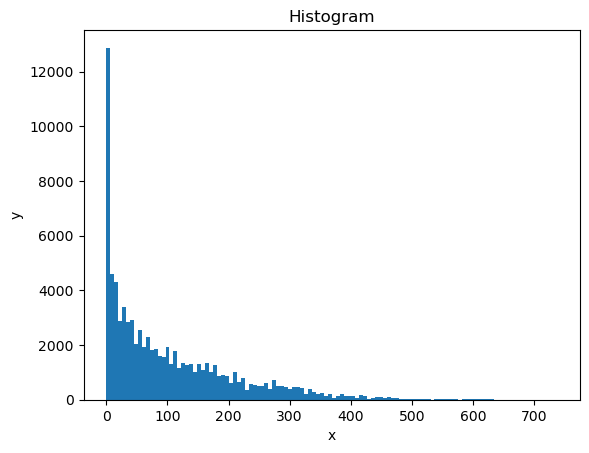

In [27]:
import matplotlib.pyplot as plt

plt.hist(train_data[col], bins='auto')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Histogram')
plt.show()

In [22]:
# Row number before dropping 
print(f"Before dropping outliers, train_data has {len(train_data)} rows.")

# Outlier sınırlarına göre filtreleme ve satırları silme işlemi
train_data = train_data[train_data['stays_in_weekend_nights'] <= 8]
train_data = train_data[train_data['stays_in_week_nights'] <= 20]
train_data = train_data[train_data['adults'] <= 6]
train_data = train_data[train_data['babies'] <= 5]
train_data = train_data[train_data['previous_bookings_not_canceled'] <= 20]
train_data = train_data[train_data['booking_changes'] <= 10]
train_data = train_data[train_data['adr'] != 5400]  # drop that one line with 5400
train_data = train_data[train_data['required_car_parking_spaces'] <= 4]
train_data = train_data[train_data['total_people'] <= 6]

# Row number after dropping 
print(f"After dropping outliers, train_data has {len(train_data)} rows.")

Before dropping outliers, train_data has 83570 rows.
After dropping outliers, train_data has 83376 rows.


# Normalization

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Train data
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)

# Validation data
val_data = pd.DataFrame(scaler.transform(val_data), columns=val_data.columns)

# Holdout test data
holdout_test_data = pd.DataFrame(scaler.transform(holdout_test_data), columns=holdout_test_data.columns)

In [24]:
train_data

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,booking_season_Winter,arrival_season_Spring,arrival_season_Summer,arrival_season_Winter,country_frequency_encoded,agent_frequency_encoded,arrival_date_week_number_sin,arrival_date_week_number_cos,booking_date_week_number_sin,booking_date_week_number_cos
0,0.0,0.464043,0.0,0.00,0.333333,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.000000,0.511233,0.470367,0.000000,0.298350,0.041586
1,0.0,1.000000,0.0,0.00,0.333333,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.000000,0.511233,0.470367,0.000000,0.529633,0.000000
2,0.0,0.009498,0.0,0.05,0.166667,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.249604,0.511233,0.470367,0.000000,0.529633,0.000000
3,0.0,0.017639,0.0,0.05,0.166667,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.249604,0.000000,0.470367,0.000000,0.588484,0.007013
4,0.0,0.018996,0.0,0.10,0.333333,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.249604,0.435576,0.470367,0.000000,0.588484,0.007013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83371,0.0,0.094980,0.0,0.10,0.333333,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.249604,0.047340,0.826554,0.878649,0.220554,0.914628
83372,0.0,0.016282,0.0,0.10,0.333333,0.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.035584,1.000000,0.826554,0.878649,0.674177,0.968682
83373,0.0,0.004071,0.0,0.10,0.333333,0.333333,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.214328,1.000000,0.826554,0.878649,0.779446,0.914628
83374,0.0,0.009498,0.0,0.10,0.166667,0.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.012472,0.511233,0.826554,0.878649,0.728415,0.944780


# Download prepared datasets

In [32]:
train_data.to_csv(r"C:\Users\selcu\Personal\İş\Uni of Mannheim 2024-2025 Spring\Data Mining\Proje\prepared datasets\train_data.csv", index=False)
val_data.to_csv(r"C:\Users\selcu\Personal\İş\Uni of Mannheim 2024-2025 Spring\Data Mining\Proje\prepared datasets\val_data.csv", index=False)
holdout_test_data.to_csv(r"C:\Users\selcu\Personal\İş\Uni of Mannheim 2024-2025 Spring\Data Mining\Proje\prepared datasets\holdout_test_data.csv", index=False)

# Baseline model evaluation

Our baseline model is: (if lead time > 60, predict 1 and otherwise 0)

In [29]:
# Our threshold is 60, but we need to scale "60" using train_data's lead_time column's parameters:
min_lead_time = train_data['lead_time'].min()
max_lead_time = train_data['lead_time'].max()
scaled_threshold = (60 - min_lead_time) / (max_lead_time - min_lead_time)
scaled_threshold

0.0814111261872456

In [33]:
scaled_threshold=0.0814111261872456

In [34]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report
)

# Run baseline model (if lead time > 60, predict 1 and otherwise 0)
y_pred = holdout_test_data['lead_time'].apply(lambda x: 1 if x > scaled_threshold else 0)

# Get real values
y_true = holdout_test_data['is_canceled']

# Evaluate
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.6147188564408956
Precision: 0.4861849650714211
Recall: 0.7027882441597588
F1 Score: 0.5747565635399975


# Simple model development trials at this point, for fun

## XGBoost

In [25]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Verileri yükleyin
# train_data = pd.read_csv('train_data.csv')  # Eğer dosyadan alıyorsanız
# val_data = pd.read_csv('val_data.csv')

# Özellikler (features) ve hedef değişken (target) tanımlanır
X_train = train_data.drop(columns=['is_canceled'])
y_train = train_data['is_canceled']

X_val = val_data.drop(columns=['is_canceled'])
y_val = val_data['is_canceled']

# XGBoost modelini oluşturun
model = xgb.XGBClassifier()

# Modeli eğitin
model.fit(X_train, y_train)

# Tahmin yapın
y_pred = model.predict(X_val)

# Modelin doğruluğunu değerlendirin
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Tüm metrikleri yazdırın
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.4036
Precision: 0.0019
Recall: 0.3509
F1 Score: 0.0037


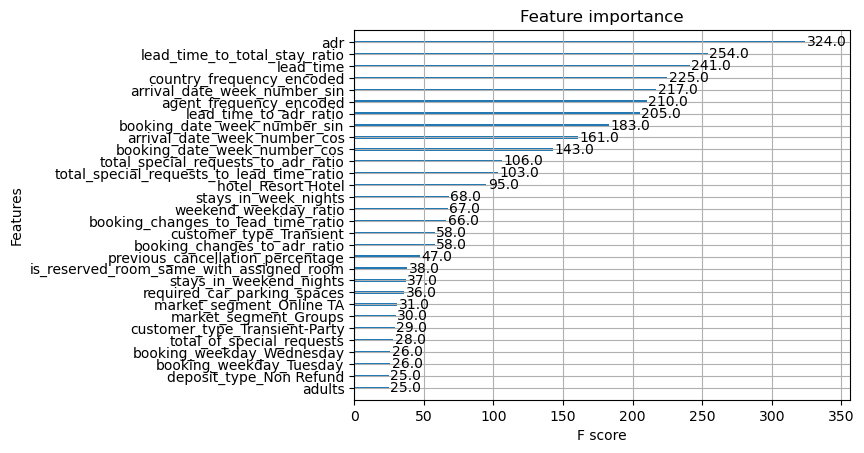

In [26]:
import xgboost as xgb
import matplotlib.pyplot as plt

# İlk 10 özelliği göstermek için max_num_features parametresini kullanıyoruz
xgb.plot_importance(model, importance_type='weight', max_num_features=30)
plt.show()

## Random Forest

In [27]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report
)
import matplotlib.pyplot as plt

# Özellikler ve hedef değişkeni ayır
X_train = train_data.drop(columns=['is_canceled'])
y_train = train_data['is_canceled']

X_val = val_data.drop(columns=['is_canceled'])
y_val = val_data['is_canceled']

# Random Forest modelini oluştur ve eğit
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Doğrulama üzerinde tahmin yap
y_pred = rf.predict(X_val)

# Değerlendirme metrikleri
print(f"Accuracy : {accuracy_score(y_val, y_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_pred):.4f}")
print(f"Recall   : {recall_score(y_val, y_pred):.4f}")
print(f"F1-score : {f1_score(y_val, y_pred):.4f}\n")

Accuracy : 0.3782
Precision: 0.0014
Recall   : 0.2632
F1-score : 0.0027



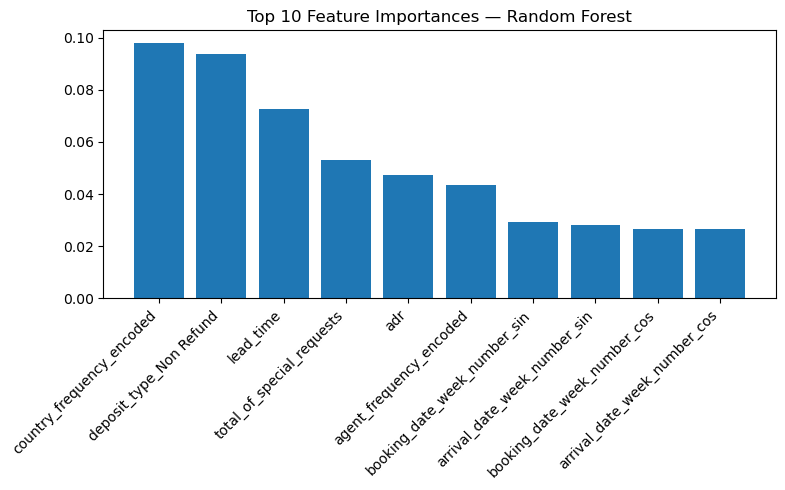

In [38]:
# Feature importances
importances = rf.feature_importances_
feat_names = np.array(X_train.columns)
top_idx = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(8, 5))
plt.bar(range(len(top_idx)), importances[top_idx], align='center')
plt.xticks(range(len(top_idx)), feat_names[top_idx], rotation=45, ha='right')
plt.title("Top 10 Feature Importances — Random Forest")
plt.tight_layout()
plt.show()

In [39]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report
)
import matplotlib.pyplot as plt

# Özellikler ve hedef değişkeni ayır
X_train = train_data.drop(columns=['is_canceled'])
y_train = train_data['is_canceled']

X_holdout_test = holdout_test_data.drop(columns=['is_canceled'])
y_holdout_test = holdout_test_data['is_canceled']

# Random Forest modelini oluştur ve eğit
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Doğrulama üzerinde tahmin yap
y_pred = rf.predict(X_holdout_test)

# Değerlendirme metrikleri
print(f"Accuracy : {accuracy_score(y_holdout_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_holdout_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_holdout_test, y_pred):.4f}")
print(f"F1-score : {f1_score(y_holdout_test, y_pred):.4f}\n")

Accuracy : 0.8942
Precision: 0.8932
Recall   : 0.8115
F1-score : 0.8504

